In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
import json
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

# Download necessary NLTK packages
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [70]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume_removeStopword_useLemm/train.csv")
df.head()

,ID,Resume_str,Category
0,28111403,president chief executive officer executive pr...,INFORMATION-TECHNOLOGY
1,29908929,business development marketing summary busines...,BUSINESS-DEVELOPMENT
2,15261348,chef restaurant manager summary chef year high...,CHEF
3,75435017,charge nurse professional summary objective ob...,HEALTHCARE
4,41152404,test analyst intern contractor profile year pr...,INFORMATION-TECHNOLOGY


In [71]:
class Doc2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=200, window=10, min_count=2, dm=1, epochs=20):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.dm = dm
        self.epochs = epochs
        self.model = None

    def fit(self, X, y=None):
        tagged_data = [
            TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) 
            for i, doc in enumerate(X)
        ]
        self.model = Doc2Vec(
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            dm=self.dm,
            epochs=self.epochs
        )
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def transform(self, X):
        return np.array([self.model.infer_vector(word_tokenize(doc.lower()), epochs=20) for doc in X])


In [72]:
d2v_model = Doc2VecTransformer(
    vector_size=100,  # Dimensionality of the document vectors
    window=5,        # Number of context words to consider to the left and right of the target word
    min_count=5,      # Ignores all words with total frequency lower than this
    dm=1,             # Defines the training algorithm: 1 means Distributed Memory, 0 means Distributed Bag of Words
    epochs=30         # Number of training epochs
)

### Support Vector Classifier

In [73]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [74]:
class_counts = df['Category'].value_counts()
min_classes = class_counts[class_counts < 0.75*class_counts.mean()].index.tolist()

print(f"Applying SMOTE to classes: {min_classes}")

target_size = int(0.75*class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applying SMOTE to classes: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [75]:
pipeline = Pipeline([
    ('d2v', d2v_model),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)),
    ('clf', SVC(probability=True, random_state=42))
])

In [76]:
param_grid = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.01, 0.03]
    },
    {
        'clf__kernel': ['poly'],
        'clf__C':      [0.1, 0.5],
        'clf__degree': [2],              
        'clf__coef0': [0.01, 0.1]
    }
]

scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= scoring,
    refit = False,
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(df['Resume_str'], df['Category'])

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")

GridSearchCV took 636.33 seconds for 6 candidates parameter settings.



In [77]:
# Convert the cross-validation results from GridSearchCV into a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort the results by the weighted F1 score in descending order
results_df = results_df.sort_values(by='mean_test_f1_weighted', ascending=False).reset_index(drop=True)

In [78]:
for i in range(len(results_df)):
    print(f"\n[{i+1}] Params: {results_df['params'][i]}")
    
    for metric in scoring:
        
        print(f"{metric.upper()}:")
        print(f"\tTRAIN:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_train_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_train_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_train_{metric}'][i]:.4f}")

        print(f"\tTEST:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_test_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_test_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_test_{metric}'][i]:.4f}\n")


[1] Params: {'clf__C': 0.01, 'clf__kernel': 'linear'}
ACCURACY:
	TRAIN:	Fold 1: 0.8514	Fold 2: 0.8345	Fold 3: 0.8351	Fold 4: 0.8244	Fold 5: 0.8219		Mean: 0.8335	Std: 0.0104
	TEST:	Fold 1: 0.5704	Fold 2: 0.5844	Fold 3: 0.5416	Fold 4: 0.5743	Fold 5: 0.5869		Mean: 0.5715	Std: 0.0162

F1_WEIGHTED:
	TRAIN:	Fold 1: 0.8499	Fold 2: 0.8342	Fold 3: 0.8335	Fold 4: 0.8241	Fold 5: 0.8210		Mean: 0.8326	Std: 0.0101
	TEST:	Fold 1: 0.5682	Fold 2: 0.5768	Fold 3: 0.5396	Fold 4: 0.5756	Fold 5: 0.5926		Mean: 0.5706	Std: 0.0174

PRECISION_WEIGHTED:
	TRAIN:	Fold 1: 0.8608	Fold 2: 0.8491	Fold 3: 0.8444	Fold 4: 0.8340	Fold 5: 0.8353		Mean: 0.8447	Std: 0.0098
	TEST:	Fold 1: 0.5873	Fold 2: 0.5842	Fold 3: 0.5557	Fold 4: 0.5912	Fold 5: 0.6234		Mean: 0.5883	Std: 0.0215

RECALL_WEIGHTED:
	TRAIN:	Fold 1: 0.8514	Fold 2: 0.8345	Fold 3: 0.8351	Fold 4: 0.8244	Fold 5: 0.8219		Mean: 0.8335	Std: 0.0104
	TEST:	Fold 1: 0.5704	Fold 2: 0.5844	Fold 3: 0.5416	Fold 4: 0.5743	Fold 5: 0.5869		Mean: 0.5715	Std: 0.0162


[2] Params: 

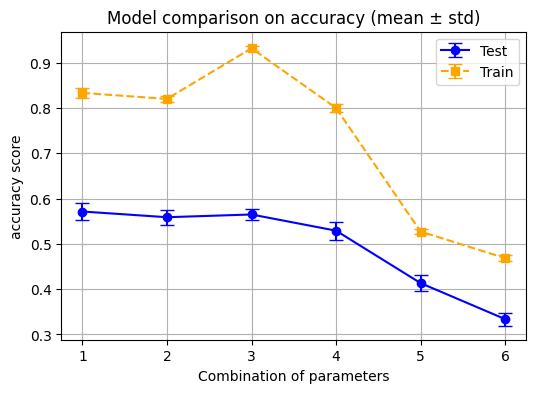

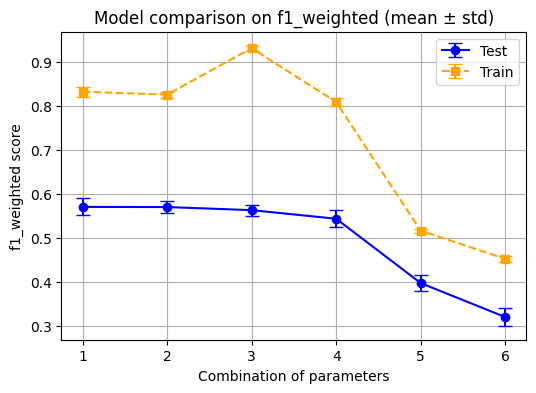

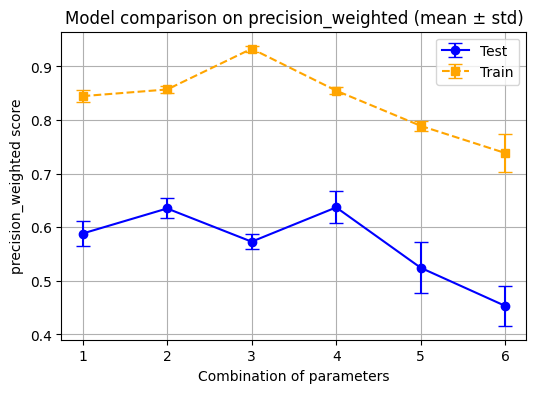

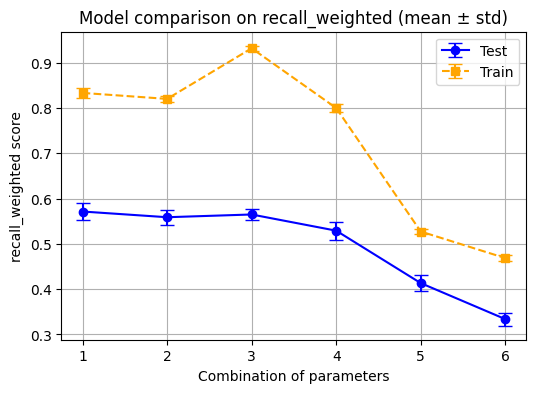

In [79]:
for metric in scoring:
    data_test = {}
    data_train = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data_test[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]
        data_train[col_name] = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_test = pd.DataFrame(data_test)
    df_train = pd.DataFrame(data_train)

    means_test = df_test.mean()
    stds_test = df_test.std()
    means_train = df_train.mean()
    stds_train = df_train.std()

    plt.figure(figsize=(max(6, len(results_df) * 0.75), 4))

    plt.errorbar(means_test.index, means_test.values, yerr=stds_test.values, fmt='-o', capsize=5, label='Test', color='blue')

    plt.errorbar(means_train.index, means_train.values, yerr=stds_train.values, fmt='--s', capsize=5, label='Train', color='orange')

    plt.ylabel(f'{metric} score')
    plt.xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric} (mean ± std)')
    plt.legend()
    plt.grid(True)
    plt.show()

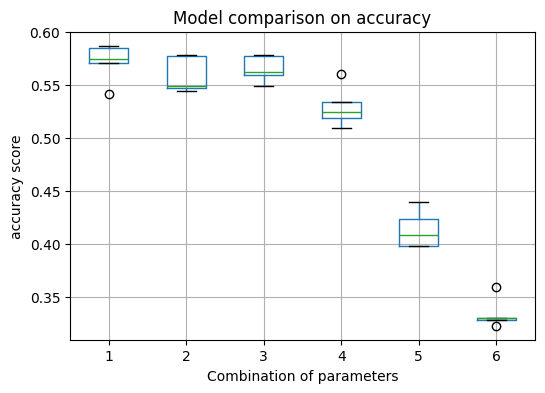

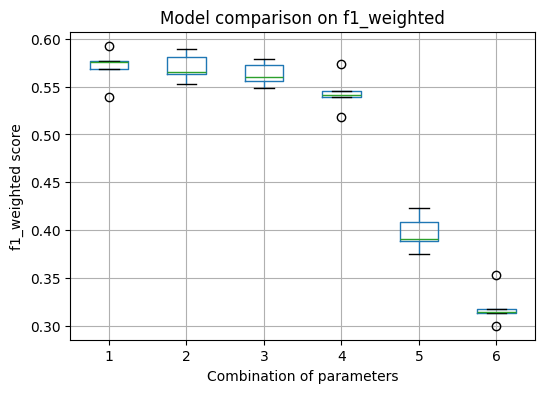

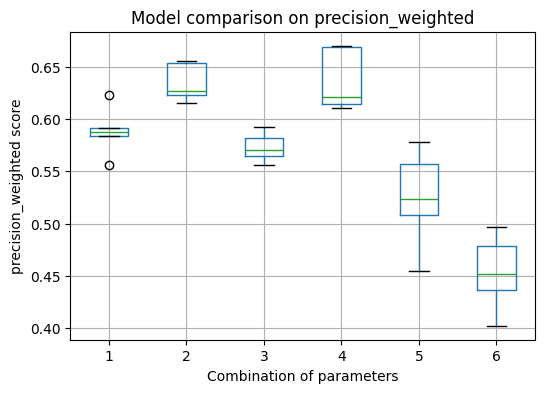

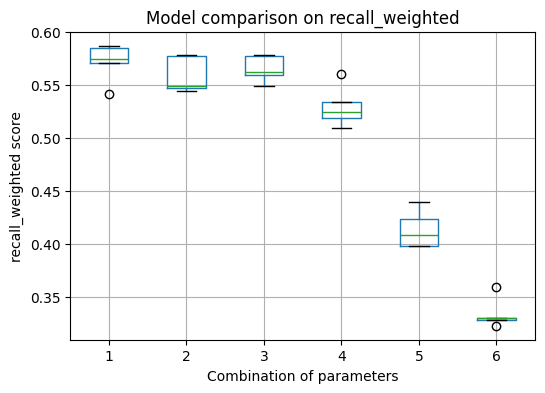

In [80]:
for metric in scoring:
    data = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_metric = pd.DataFrame(data)
    ax = df_metric.boxplot(figsize=(max(6, len(results_df) * 0.75), 4))
    ax.set_ylabel(f'{metric} score')
    ax.set_xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric}')
    plt.grid(True)
    plt.show()

In [81]:
output_file = "compare/results.json"
section_key = "D2V"

# Only process the first row
i = 0
entry = {
    "params": results_df['params'][i],
    "metrics": {}
}

for metric in scoring:
    train_folds = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]
    test_folds = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    entry["metrics"][metric] = {
        "train": {
            "folds": train_folds,
            "mean": results_df[f'mean_train_{metric}'][i],
            "std": results_df[f'std_train_{metric}'][i]
        },
        "test": {
            "folds": test_folds,
            "mean": results_df[f'mean_test_{metric}'][i],
            "std": results_df[f'std_test_{metric}'][i]
        }
    }

# Load or initialize the JSON structure
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        data = json.load(f)
else:
    data = {}

data[section_key] = entry

# Write the full updated JSON back to file
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Saved the best model")

Saved the best model
